# Postprocess to compute the GMT input of strain with triangular mesh

We compute the relative strain change from the output of daily strains from the GNSS location.
The strain tensor is computed in the PyTAGS with the reference location written in the header of `.neu` file.
We then select the reference date, in this notebook at 2009/01/03, and compute the change of strains from the reference state to investigate the evolution of dilation and max shear strain. Note that since we compute the change in max shear, it can be negative value althugh the absolute max shear is always positive.

2023.1.25 Kurama Okubo

- 2023.5.1 update for the dataset in 2023/04/16.

- 2023.5.18 update for the strain components associated with fault normal and fault shear

- 2023.7.12 update for projection of maximum compressive stress. We also recompute E1 and E2 with the cumulative strain 

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import h5py
import glob

import shutil
from tqdm import tqdm

from pyproj import Proj # used to convert between utm and lat lon

from BP_rotate_strain import rotate_strain, compute_axialstrain

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["xtick.minor.width"] = 0
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True


# Workflow
1. Read the subnetworks overview in output to make the xyz file of mesh edges.
2. Make the GPS location file with station name
3. make polygon input file for the strain field
- example of input file for polygon with the magnitude: https://github.com/GenericMappingTools/gmt/issues/3101
4. make the input file of maximum principal stress at the center of meshes.

# Read subnetworks

In [3]:
df_subnet = pd.read_csv("../compute_triangularstrain/output/subnetworks_triangulated_overview.txt", header=0, sep=' ', index_col=False)
df_subnet.head()

,#Site1,Lon1,Lat1,Site2,Lon2,Lat2,Site3,Lon3,Lat3
0,p547,-119.9094,35.9347,p544,-119.7380,35.7313,p545,-119.5358,35.4998
1,p286,-120.8531,36.5159,p299,-120.7102,36.2568,gr8r,-120.4157,36.3990
2,p284,-120.9068,35.9333,p288,-120.8789,36.1402,p173,-121.2903,35.9457
3,p288,-120.8789,36.1402,p174,-121.0509,36.3022,p173,-121.2903,35.9457
4,p284,-120.9068,35.9333,p289,-120.7488,36.1068,p288,-120.8789,36.1402


In [4]:
tri_edges = []
for i, row in df_subnet.iterrows():
    loc1 = [row.Lon1, row.Lat1]
    loc2 = [row.Lon2, row.Lat2]
    loc3 = [row.Lon3, row.Lat3]
    # line 1
    line1 =  np.hstack((loc1, loc2))
    if not list(line1) in tri_edges:
        tri_edges.append(list(line1))
    # line 2
    line2 =  np.hstack((loc2, loc3))
    if not list(line2) in tri_edges:
        tri_edges.append(list(line2))
    # line 3
    line3 =  np.hstack((loc3, loc1))
    if not list(line3) in tri_edges:
        tri_edges.append(list(line3))
        

In [5]:
# save to xy file to plot edges
with open("../data/triangular_edges.xy", "wt") as fo:
    for edge in tri_edges:
        fo.write(f">\n{edge[0]} {edge[1]}\n{edge[2]} {edge[3]}\n")

# Make location file of GPS stations

In [6]:
df_site = pd.read_csv("../data/BP_GPSstations.txt", header=None, index_col=False)

In [7]:
with open("../data/BP_GPSstations_GMT.xy", "wt") as fo:
    for i, row in df_site.iterrows():
        fo.write(f"{row[0]} {row[1]} {row[7]}\n")

# Make polygon input from the PyTAGS output

In [8]:
df_site.head()

,0,1,2,3,4,5,6,7
0,-120.433695,35.939352,0,0,0,0,0,cand
1,-120.430818,35.888383,0,0,0,0,0,carh
2,-120.750751,35.791610,0,0,0,0,0,crbt
3,-120.415731,36.399015,0,0,0,0,0,gr8r
4,-120.479493,35.866713,0,0,0,0,0,hogs


In [9]:
filist = glob.glob("../compute_triangularstrain/output/triangle*.txt")

df_strain_all = pd.DataFrame(columns=["triID", "lon1", "lat1", "lon2", "lat2", "lon3", "lat3", "year", "doy", "E1", "E2", "Een", "w", "theta", "Eee", "Enn", "theta_SHmax", "e_SHmax"])

# finame = filist[5]
for finame in filist:
    triname, sta1, sta2, sta3 = os.path.basename(finame).split('.txt')[0].split('_')
    stations = [sta1, sta2, sta3]
    triid = int(triname.split('triangle')[1])

    # obtain the station location
    loc = []
    for st in stations:
        row = df_site[df_site[7] == st]
        lon1, lat1 = (row[0].values[0], row[1].values[0])
        loc.append([lon1, lat1])

    # read PyTAGS output
    df_strain = pd.read_csv(finame, header=None, comment="#", sep=" ", 
                names=["year", "doy", "Decimal time", "E1", "E2", "Een", "w", "theta", "Eee", "Enn", "theta_SHmax", "e_SHmax"], index_col=False)
    # add columns of triID and locations of stations

    df_strain["triID"] = triid
    for i in range(3):
        df_strain[f"lon{i+1}"] = loc[i][0]
        df_strain[f"lat{i+1}"] = loc[i][1]

    # join to the master dataframe
    df_strain_all = pd.concat([df_strain_all, df_strain]) 
    

**NOTE:** the native output of PyTAGS for `theta` is the azimuth of **maximum principal strain, i.e. maximum extensive strain,**  from clockwise north, while `theta_SHmax` is the angle of **minimum principal strain, i.e. maximum compressional strain,** from east anticlockwise with the sign convention such that the positive extension. Then, if the `theta` is negative, `+pi` is added. 
Thus, 90-`theta` + 90 = `theta_SHmax`.

<img src="SHmax_schematic.png" alt="SHmax_schematic" width="200"/>


In [10]:
# check if the theta and newly output theta_SHmax is consistent
assert (np.abs(180 - df_strain_all["theta"] - df_strain_all["theta_SHmax"])<1e-12).all()

In [11]:
df_strain_all["theta"]

0       104.97
1       104.91
2       104.78
3       104.96
4       104.99
         ...  
3469     80.73
3470     81.14
3471     80.81
3472     80.96
3473     80.74
Name: theta, Length: 548584, dtype: float64

In [12]:
df_strain_all["theta_SHmax"]

0       75.03
1       75.09
2       75.22
3       75.04
4       75.01
        ...  
3469    99.27
3470    98.86
3471    99.19
3472    99.04
3473    99.26
Name: theta_SHmax, Length: 548584, dtype: float64

In [13]:
print("data number check: the total year is {} in average.".format(len(df_strain_all)/df_strain_all.triID.max()/365))

data number check: the total year is 11.928332246140464 in average.


In [14]:
# Compute relative strain change
# We set 2009.3 as the reference time stamp
ref_year = 2009
ref_doy = 3 # some station has a lack of data on the beginning of 2009, so we start from doy=3 to obtain references of all the triangulars.
df_refsnap = df_strain_all[(df_strain_all["year"]==ref_year) & (df_strain_all["doy"]==ref_doy)].sort_values(by="triID")

In [15]:
df_refsnap

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,E2,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time
3,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2009,3,6.137400e-05,-3.774700e-06,2.118900e-05,-1.551900e-05,69.71,5.354000e-05,4.059100e-06,110.29,-3.774700e-06,2009.0096
3,2,-120.853056,36.515909,-120.710198,36.256819,-120.415731,36.399015,2009,3,7.037500e-07,-3.827700e-08,3.505500e-07,-2.508600e-07,54.56,4.542500e-07,2.112200e-07,125.44,-3.827700e-08,2009.0096
3,3,-120.906843,35.933259,-120.878900,36.140206,-121.290334,35.945716,2009,3,1.027900e-08,-4.853600e-06,2.018100e-06,2.943600e-08,28.04,-3.778700e-06,-1.064600e-06,151.96,-4.853600e-06,2009.0096
3,4,-120.878900,36.140206,-121.050898,36.302151,-121.290334,35.945716,2009,3,2.306700e-07,-2.695600e-06,6.286800e-07,7.488500e-07,12.72,-2.553600e-06,8.871600e-08,167.28,-2.695600e-06,2009.0096
3,5,-120.906843,35.933259,-120.748815,36.106841,-120.878900,36.140206,2009,3,3.687300e-06,-6.621300e-07,-4.044300e-07,-1.582200e-06,95.36,3.649400e-06,-6.242000e-07,84.64,-6.621300e-07,2009.0096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,122,-120.370952,35.747929,-120.292599,35.688910,-120.285255,35.806669,2009,3,7.424600e-06,-1.050500e-06,-3.667600e-06,-1.076600e-07,119.97,5.309700e-06,1.064500e-06,60.03,-1.050500e-06,2009.0096
3,123,-120.389458,35.841057,-120.370952,35.747929,-120.345213,35.837808,2009,3,3.764600e-05,-7.645800e-06,-1.994500e-05,-1.678400e-05,120.87,2.572500e-05,4.275000e-06,59.13,-7.645800e-06,2009.0096
3,124,-120.370952,35.747929,-120.389458,35.841057,-120.443057,35.832596,2009,3,3.467700e-05,6.096700e-06,-7.384800e-06,-5.349800e-06,105.56,3.262100e-05,8.152800e-06,74.44,6.096700e-06,2009.0096
3,125,-120.402382,35.880812,-120.389458,35.841057,-120.345213,35.837808,2009,3,2.925100e-05,-5.745900e-05,-1.108500e-05,-3.107300e-05,97.41,2.781000e-05,-5.601800e-05,82.59,-5.745900e-05,2009.0096


In [16]:
df_strain_all

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,E2,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time
0,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,0,0.000171,-0.000065,-0.000059,-0.000085,104.97,0.000156,-0.000050,75.03,-0.000065,2009.0014
1,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,1,0.000171,-0.000066,-0.000059,-0.000085,104.91,0.000156,-0.000050,75.09,-0.000066,2009.0041
2,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,2,0.000172,-0.000066,-0.000059,-0.000084,104.78,0.000157,-0.000050,75.22,-0.000066,2009.0068
3,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,3,0.000172,-0.000065,-0.000059,-0.000085,104.96,0.000156,-0.000050,75.04,-0.000065,2009.0096
4,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,4,0.000172,-0.000066,-0.000059,-0.000085,104.99,0.000156,-0.000050,75.01,-0.000066,2009.0123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,235,0.000009,-0.000019,0.000005,-0.000012,80.73,0.000009,-0.000019,99.27,-0.000019,2018.6452
3470,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,236,0.000009,-0.000020,0.000004,-0.000011,81.14,0.000008,-0.000019,98.86,-0.000020,2018.6479
3471,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,237,0.000009,-0.000018,0.000004,-0.000012,80.81,0.000008,-0.000017,99.19,-0.000018,2018.6507
3472,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,238,0.000009,-0.000020,0.000005,-0.000012,80.96,0.000009,-0.000019,99.04,-0.000020,2018.6534


# Subtract the reference strain from the cumulative strain field

In [17]:
df_deltastrain_all = df_strain_all.copy()
# subtract the strain tensor at reference year's strain field with respect to the triangles.
for i, row_snap in df_refsnap.iterrows():
    # Update: The principal strains E1 and E2 needs to be recomputed from the cumulative strain. This is not the case if principal orientation does not change through the analysis period.
#     df_deltastrain_all.loc[df_deltastrain_all["triID"] == row_snap["triID"], 'E1'] = \
#                 df_strain_all[df_strain_all["triID"] == row_snap["triID"]]["E1"].sub(row_snap["E1"])
#     df_deltastrain_all.loc[df_deltastrain_all["triID"] == row_snap["triID"], 'E2'] = \
#                 df_strain_all[df_strain_all["triID"] == row_snap["triID"]]["E2"].sub(row_snap["E2"])
    df_deltastrain_all.loc[df_deltastrain_all["triID"] == row_snap["triID"], 'Een'] = \
                df_strain_all[df_strain_all["triID"] == row_snap["triID"]]["Een"].sub(row_snap["Een"])
    # update: add Eee and Enn
    df_deltastrain_all.loc[df_deltastrain_all["triID"] == row_snap["triID"], 'Eee'] = \
                df_strain_all[df_strain_all["triID"] == row_snap["triID"]]["Eee"].sub(row_snap["Eee"])
    df_deltastrain_all.loc[df_deltastrain_all["triID"] == row_snap["triID"], 'Enn'] = \
                df_strain_all[df_strain_all["triID"] == row_snap["triID"]]["Enn"].sub(row_snap["Enn"])

In [18]:
df_deltastrain_all

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,E2,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time
0,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,0,0.000171,-0.000065,1.800000e-07,-0.000085,104.97,-8.200000e-07,-9.000000e-09,75.03,-0.000065,2009.0014
1,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,1,0.000171,-0.000066,2.710000e-07,-0.000085,104.91,-6.600000e-07,-4.890000e-07,75.09,-0.000066,2009.0041
2,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,2,0.000172,-0.000066,6.310000e-07,-0.000084,104.78,3.000000e-07,-5.580000e-07,75.22,-0.000066,2009.0068
3,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,3,0.000172,-0.000065,0.000000e+00,-0.000085,104.96,0.000000e+00,0.000000e+00,75.04,-0.000065,2009.0096
4,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,4,0.000172,-0.000066,-1.750000e-07,-0.000085,104.99,1.000000e-08,-4.500000e-08,75.01,-0.000066,2009.0123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,235,0.000009,-0.000019,5.357980e-06,-0.000012,80.73,5.904800e-06,-2.051630e-05,99.27,-0.000019,2018.6452
3470,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,236,0.000009,-0.000020,5.120480e-06,-0.000011,81.14,5.406800e-06,-2.089630e-05,98.86,-0.000020,2018.6479
3471,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,237,0.000009,-0.000018,4.995980e-06,-0.000012,80.81,5.562300e-06,-1.895830e-05,99.19,-0.000018,2018.6507
3472,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,238,0.000009,-0.000020,5.348480e-06,-0.000012,80.96,5.904800e-06,-2.121630e-05,99.04,-0.000020,2018.6534


In [19]:
def compute_principal_orientation(Eee, Enn, Een):
    return 1/2.0*math.atan2(2.0*Een,Eee-Enn)

def compute_e1(Eee, Enn, Een, theta):
    return Eee*math.cos(theta)*math.cos(theta)+Enn*math.sin(theta)*math.sin(theta)+2*Een*math.sin(theta)*math.cos(theta)

def compute_e2(Eee, Enn, Een, theta):
    return Eee*math.sin(theta)*math.sin(theta)+Enn*math.cos(theta)*math.cos(theta)-2*Een*math.sin(theta)*math.cos(theta)


In [20]:
# def compute_principal_orientation_pytags(Eee, Enn, Een):
#     # code taken from PyTAGS: Note that it uses Enn-Eee
#     # atan2(0, 0) returns 0; so the principal orientation at reference snap is 0.
#     theta = 1/2.0*math.atan2(2.0*Een,Enn-Eee)
#     if (theta < 0):
#         theta = math.pi+theta
#     return theta

# def compute_e1e2_pytags(Eee, Enn, Een, comp):
#     # we recompute theta following the original code
#     theta = 1/2.0*math.atan2(2.0*Een,Enn-Eee)
#     e1 = Eee*math.cos(theta)*math.cos(theta)+Enn*math.sin(theta)*math.sin(theta)-2*Een*math.sin(theta)*math.cos(theta)
#     e2 = Eee*math.sin(theta)*math.sin(theta)+Enn*math.cos(theta)*math.cos(theta)+2*Een*math.sin(theta)*math.cos(theta)

#     if (e2 > e1):
#         e1new = e2
#         e2new = e1
#         e1 = e1new
#         e2 = e2new

#     if comp=="e1":
#         return e1
#     else:
#         return e2

In [21]:
df_deltastrain_all["theta"] = df_deltastrain_all.apply(lambda x: compute_principal_orientation(x.Eee, x.Enn, x.Een), axis=1)
df_deltastrain_all["E1"] = df_deltastrain_all.apply(lambda x: compute_e1(x.Eee, x.Enn, x.Een, x.theta), axis=1)
df_deltastrain_all["E2"] = df_deltastrain_all.apply(lambda x: compute_e2(x.Eee, x.Enn, x.Een, x.theta), axis=1)

# convert from radian to degree
df_deltastrain_all["theta"] = df_deltastrain_all.apply(lambda x: np.rad2deg(x.theta), axis=1)


In [22]:
# The code below are test to check the consistency to the PyTAGS code associated with the principal strains.

# df_deltastrain_all["thetaPT"] = df_deltastrain_all.apply(lambda x: compute_principal_orientation_pytags(x.Eee, x.Enn, x.Een), axis=1)
# df_deltastrain_all["E1PT"] = df_deltastrain_all.apply(lambda x: compute_e1e2_pytags(x.Eee, x.Enn, x.Een, "e1"), axis=1)
# df_deltastrain_all["E2PT"] = df_deltastrain_all.apply(lambda x: compute_e1e2_pytags(x.Eee, x.Enn, x.Een, "e2"), axis=1)

# # convert from radian to degree
# df_deltastrain_all["thetaPT"] = df_deltastrain_all.apply(lambda x: np.rad2deg(x.thetaPT), axis=1)

# #---check if values are identical---#
# assert (np.abs(df_deltastrain_all["E1"] - df_deltastrain_all["E1PT"]) < 1e-12).all()
# assert (np.abs(df_deltastrain_all["E2"] - df_deltastrain_all["E2PT"]) < 1e-12).all()
# df1 = df_deltastrain_all[df_deltastrain_all["thetaPT"] > 0] # skip the reference snap
# assert (np.abs(90-df1["thetaPT"] - df1["theta"]) < 1e-12).all() # thetaPT is azimuth from north and theta is angle from east.

In [23]:
# check if the offset of strains are removed.
df_deltastrain_all.loc[(df_deltastrain_all.doy==3) & (df_deltastrain_all.year==2009)].sort_values(by="triID")

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,E2,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time
3,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2009,3,0.0,0.0,0.0,-1.551900e-05,0.0,0.0,0.0,110.29,-3.774700e-06,2009.0096
3,2,-120.853056,36.515909,-120.710198,36.256819,-120.415731,36.399015,2009,3,0.0,0.0,0.0,-2.508600e-07,0.0,0.0,0.0,125.44,-3.827700e-08,2009.0096
3,3,-120.906843,35.933259,-120.878900,36.140206,-121.290334,35.945716,2009,3,0.0,0.0,0.0,2.943600e-08,0.0,0.0,0.0,151.96,-4.853600e-06,2009.0096
3,4,-120.878900,36.140206,-121.050898,36.302151,-121.290334,35.945716,2009,3,0.0,0.0,0.0,7.488500e-07,0.0,0.0,0.0,167.28,-2.695600e-06,2009.0096
3,5,-120.906843,35.933259,-120.748815,36.106841,-120.878900,36.140206,2009,3,0.0,0.0,0.0,-1.582200e-06,0.0,0.0,0.0,84.64,-6.621300e-07,2009.0096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,122,-120.370952,35.747929,-120.292599,35.688910,-120.285255,35.806669,2009,3,0.0,0.0,0.0,-1.076600e-07,0.0,0.0,0.0,60.03,-1.050500e-06,2009.0096
3,123,-120.389458,35.841057,-120.370952,35.747929,-120.345213,35.837808,2009,3,0.0,0.0,0.0,-1.678400e-05,0.0,0.0,0.0,59.13,-7.645800e-06,2009.0096
3,124,-120.370952,35.747929,-120.389458,35.841057,-120.443057,35.832596,2009,3,0.0,0.0,0.0,-5.349800e-06,0.0,0.0,0.0,74.44,6.096700e-06,2009.0096
3,125,-120.402382,35.880812,-120.389458,35.841057,-120.345213,35.837808,2009,3,0.0,0.0,0.0,-3.107300e-05,0.0,0.0,0.0,82.59,-5.745900e-05,2009.0096


In [24]:
# check if all the reference strain is zero.
# df_deltastrain_all.loc[(df_deltastrain_all.doy==3) & (df_deltastrain_all.year==2009)].sort_values(by="triID").plot(y = "Een")

In [25]:
# make snapshots of polygon file 
polyoutputdir = "../data/strain_snapshot"
if not os.path.exists(polyoutputdir):
    os.makedirs(polyoutputdir)

In [26]:
snapyear = 2010
snapdoy = 165

In [27]:
df_snap = df_deltastrain_all[(df_deltastrain_all["year"] == snapyear) & (df_deltastrain_all["doy"] == snapdoy)].sort_values(by="triID")
df_snap
# if df_snap.empty:# no data exists in this time snap
#     continue

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,E2,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time
530,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2010,165,2.268833e-06,-2.201233e-06,8.030000e-07,-1.337400e-05,79.472042,-2.052000e-06,2.119600e-06,112.08,-2.740400e-06,2010.4534
529,2,-120.853056,36.515909,-120.710198,36.256819,-120.415731,36.399015,2010,165,7.618042e-08,-9.328104e-07,-4.139650e-07,-2.534700e-08,-27.570072,-1.399600e-07,-7.166700e-07,85.60,-5.103200e-07,2010.4534
530,3,-120.906843,35.933259,-120.878900,36.140206,-121.290334,35.945716,2010,165,1.823230e-07,-2.902295e-08,-1.011000e-07,-1.213200e-08,-36.541318,1.074000e-07,4.590000e-08,152.34,-4.676100e-06,2010.4534
530,4,-120.878900,36.140206,-121.050898,36.302151,-121.290334,35.945716,2010,165,6.047094e-08,-7.776936e-09,-3.218000e-08,6.562900e-07,-35.283661,3.770000e-08,1.499400e-08,167.76,-2.645400e-06,2010.4534
530,5,-120.906843,35.933259,-120.748815,36.106841,-120.878900,36.140206,2010,165,5.279023e-08,-1.288302e-07,-5.019000e-08,-1.597000e-06,-73.224088,-1.137000e-07,3.766000e-08,83.78,-6.360800e-07,2010.4534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,122,-120.370952,35.747929,-120.292599,35.688910,-120.285255,35.806669,2010,165,7.703139e-07,-9.550339e-07,-4.900000e-09,-9.004900e-07,-0.162721,7.703000e-07,-9.550200e-07,64.55,-1.638000e-06,2010.4534
530,123,-120.389458,35.841057,-120.370952,35.747929,-120.345213,35.837808,2010,165,3.054378e-06,-1.092478e-06,-1.484000e-06,-1.884500e-05,-22.851235,2.429000e-06,-4.671000e-07,59.80,-8.664500e-06,2010.4534
530,124,-120.370952,35.747929,-120.389458,35.841057,-120.443057,35.832596,2010,165,9.677798e-07,6.252020e-08,4.010000e-08,-5.650300e-06,2.541345,9.660000e-07,6.430000e-08,74.96,6.244300e-06,2010.4534
530,125,-120.402382,35.880812,-120.389458,35.841057,-120.345213,35.837808,2010,165,2.671459e-06,-4.800459e-06,-6.910000e-07,-3.431300e-05,-5.329376,2.607000e-06,-4.736000e-06,82.76,-6.225000e-05,2010.4534


In [28]:
Ntri = len(df_refsnap)
# df_refsnap

## Compute orientation of maximum compressive strain using cumulative strain

The `theta_SHmax` is computed from the reference coordinate described in the header of `.neu` raw data. We recompute `theta_SHmax_delta` using the cumulative strain from the reference snapshot.


In [29]:
def compute_theta_SHmax(Eee, Enn, Een):
    # compute the pricipal orientation
    theta_p = 0.5*np.arctan2(2*Een, (Eee - Enn))
    theta_pdeg = np.rad2deg(theta_p)
    # SHmax is orthogonal to the principal axis corresponding to the maximum extensive strain
    theta_SHmax = theta_pdeg + 90
    if np.abs(theta_SHmax - 180) < 1e-12:
        theta_SHmax = 0 # unify the zero and 180 degrees to zero.
    return theta_SHmax

def compute_e_SHmax(Eee, Enn, Een, theta_SHmax):
    # compute the maximum compressive strain
    theta_SHmax_rad = np.deg2rad(theta_SHmax)
    e_SHmax = Eee*np.cos(theta_SHmax_rad)**2 + Een*np.sin(2*theta_SHmax_rad) + Enn*np.sin(theta_SHmax_rad)**2
    return e_SHmax
        

In [30]:
df_deltastrain_all["theta_SHmax_delta"] = df_deltastrain_all.apply(lambda x: compute_theta_SHmax(x.Eee, x.Enn, x.Een), axis=1)
df_deltastrain_all["e_SHmax_delta"] = df_deltastrain_all.apply(lambda x: compute_e_SHmax(x.Eee, x.Enn, x.Een, x.theta_SHmax_delta), axis=1)
df_deltastrain_all

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,...,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time,theta_SHmax_delta,e_SHmax_delta
0,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,0,2.915555e-08,...,1.800000e-07,-0.000085,78.031868,-8.200000e-07,-9.000000e-09,75.03,-0.000065,2009.0014,168.031868,-8.581556e-07
1,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,1,-2.903324e-07,...,2.710000e-07,-0.000085,53.755195,-6.600000e-07,-4.890000e-07,75.09,-0.000066,2009.0041,143.755195,-8.586676e-07
2,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,2,6.340216e-07,...,6.310000e-07,-0.000084,27.894633,3.000000e-07,-5.580000e-07,75.22,-0.000066,2009.0068,117.894633,-8.920216e-07
3,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,3,0.000000e+00,...,0.000000e+00,-0.000085,0.000000,0.000000e+00,0.000000e+00,75.04,-0.000065,2009.0096,90.000000,0.000000e+00
4,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,4,1.596475e-07,...,-1.750000e-07,-0.000085,-40.534705,1.000000e-08,-4.500000e-08,75.01,-0.000066,2009.0123,49.465295,-1.946475e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,235,6.950006e-06,...,5.357980e-06,-0.000012,11.038329,5.904800e-06,-2.051630e-05,99.27,-0.000019,2018.6452,101.038329,-2.156151e-05
3470,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,236,6.368456e-06,...,5.120480e-06,-0.000011,10.636582,5.406800e-06,-2.089630e-05,98.86,-0.000020,2018.6479,100.636582,-2.185796e-05
3471,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,237,6.541138e-06,...,4.995980e-06,-0.000012,11.085263,5.562300e-06,-1.895830e-05,99.19,-0.000018,2018.6507,101.085263,-1.993714e-05
3472,89,-120.24496,35.686725,-120.216191,35.693819,-120.239030,35.694331,2018,238,6.921450e-06,...,5.348480e-06,-0.000012,10.762502,5.904800e-06,-2.121630e-05,99.04,-0.000020,2018.6534,100.762502,-2.223295e-05


In [31]:
# assert if E2 and e_SHmax_delta are identical
df2 = df_deltastrain_all[df_deltastrain_all["theta"]>0]
res = np.abs(df2["E2"] - df2["e_SHmax_delta"])
(res < 1e-12).all()

True

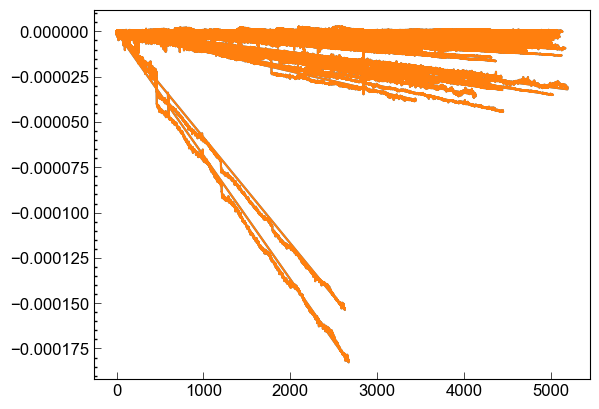

In [32]:
plt.plot(df_deltastrain_all["E2"])
plt.plot(df_deltastrain_all["e_SHmax_delta"])

## Compute rotation angle associated with the San Andreas fault
We compute the rotation angle with the approximated planar plane along the San Andreas fault.

In [33]:
approx_faultloc = [-120.6, 36.04, -120.35, 35.82] # selected with try and error
approx_north= [-120.35, 36.04, -120.35, 35.82]

# save the location of approximated fault
with open('../data/approx_faultloc.txt', 'w') as f:
    f.write(f"{approx_faultloc[0]}, {approx_faultloc[1]}\n{approx_faultloc[2]}, {approx_faultloc[3]}")


# compute utm corrdinate using pyproj
# You need to install pyproj in the environment.
utm_zone_BP = 10
p = Proj(proj='utm',zone=utm_zone_BP,ellps='WGS84', preserve_units=False)
A = np.array(p(approx_faultloc[0], approx_faultloc[1]))
B = np.array(p(approx_faultloc[2], approx_faultloc[3]))
AN = np.array(p(approx_north[0], approx_north[1]))

nvec1 = B-A
nvec2 = B-AN

theta_BPangle = np.rad2deg(np.arccos(np.dot(nvec1, nvec2)/(np.linalg.norm(nvec1)*np.linalg.norm(nvec2))))
print(f"The rotation angle onto the approximated fault is {theta_BPangle:.4f} degree from north.")

The rotation angle onto the approximated fault is 42.6712 degree from north.


In [34]:
# output the axes annotation
# convert the approx fault
p = Proj(proj='utm', zone=utm_zone_BP,ellps='WGS84', preserve_units=False)

linelen_factor = 0.1 # shrink the length of line
axis_shift  = np.array([-2e3, 3.5e3]) # [km] shift the origin of axes from southern end

vec_fp = A - B
vec_fn = np.array([vec_fp[1], -vec_fp[0]])

vec_fp_shift = linelen_factor*vec_fp + B + axis_shift
vec_fn_shift = linelen_factor*vec_fn + B + axis_shift

axes_origin = p(B[0] + axis_shift[0],  B[1] + axis_shift[1], inverse=True)
axes_fp = p(vec_fp_shift[0], vec_fp_shift[1], inverse=True)
axes_fn = p(vec_fn_shift[0],  vec_fn_shift[1], inverse=True)

with open("../data/fault_approx.txt", "w") as fo:
    fo.write(f"{approx_faultloc[0]} {approx_faultloc[1]}\n")
    fo.write(f"{approx_faultloc[2]} {approx_faultloc[3]}\n")
    fo.write("> fault parallel\n")
    fo.write(f"{axes_origin[0]} {axes_origin[1]}\n")
    fo.write(f"{axes_fp[0]} {axes_fp[1]}\n")
    fo.write("> fault normal\n")
    fo.write(f"{axes_origin[0]} {axes_origin[1]}\n")
    fo.write(f"{axes_fn[0]} {axes_fn[1]}")    

In [35]:
df_strain_all.sort_values(by="triID")

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,E2,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time
1433,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2012,338,0.000065,-1.986100e-06,0.000025,-0.000012,65.79,0.000053,0.000009,114.21,-1.986100e-06,2012.9249
2398,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,308,0.000067,-5.617000e-07,0.000028,-0.000008,61.77,0.000052,0.000015,118.23,-5.617000e-07,2015.8452
2399,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,309,0.000067,-4.555800e-07,0.000028,-0.000007,61.39,0.000051,0.000015,118.61,-4.555800e-07,2015.8479
2400,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,310,0.000068,-4.864400e-07,0.000029,-0.000007,61.42,0.000053,0.000015,118.58,-4.864400e-07,2015.8507
2401,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,311,0.000067,-6.087500e-07,0.000028,-0.000008,61.96,0.000052,0.000014,118.04,-6.087500e-07,2015.8534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,346,0.000031,-5.170900e-05,0.000011,-0.000012,82.46,0.000029,-0.000050,97.54,-5.170900e-05,2010.9493
712,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,347,0.000031,-5.169700e-05,0.000011,-0.000012,82.49,0.000029,-0.000050,97.51,-5.169700e-05,2010.9521
713,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,348,0.000031,-5.171400e-05,0.000011,-0.000012,82.47,0.000029,-0.000050,97.53,-5.171400e-05,2010.9548
699,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,334,0.000031,-5.153900e-05,0.000011,-0.000012,82.47,0.000029,-0.000050,97.53,-5.153900e-05,2010.9164


# Make the snapshot

In [36]:
# make snapshots of polygon file 
for sttype in ["dilation", "maxshear", "SHmax", "Eee", "Enn", "Een", "Efn", "Efp", "Ess", "ESHmax"]:
    polyoutputdir_sttype = polyoutputdir+f"/{sttype}"
    if not os.path.exists(polyoutputdir_sttype):
        os.makedirs(polyoutputdir_sttype)

In [37]:
# save dataframe containing all the strain data
df_deltastrain_all.sort_values(by="triID").to_csv("../data/df_deltastrain_all.csv", index=False)

In [38]:
df_deltastrain_all.head()

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,...,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time,theta_SHmax_delta,e_SHmax_delta
0,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,0,2.915555e-08,...,1.800000e-07,-0.000085,78.031868,-8.200000e-07,-9.000000e-09,75.03,-0.000065,2009.0014,168.031868,-8.581556e-07
1,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,1,-2.903324e-07,...,2.710000e-07,-0.000085,53.755195,-6.600000e-07,-4.890000e-07,75.09,-0.000066,2009.0041,143.755195,-8.586676e-07
2,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,2,6.340216e-07,...,6.310000e-07,-0.000084,27.894633,3.000000e-07,-5.580000e-07,75.22,-0.000066,2009.0068,117.894633,-8.920216e-07
3,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,3,0.000000e+00,...,0.000000e+00,-0.000085,0.000000,0.000000e+00,0.000000e+00,75.04,-0.000065,2009.0096,90.000000,0.000000e+00
4,115,-120.47328,35.899789,-120.458828,35.921913,-120.478432,35.919909,2009,4,1.596475e-07,...,-1.750000e-07,-0.000085,-40.534705,1.000000e-08,-4.500000e-08,75.01,-0.000066,2009.0123,49.465295,-1.946475e-07


In [39]:
np.unique(df_deltastrain_all.triID)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126], dtype=object)

<AxesSubplot:xlabel='Decimal time'>

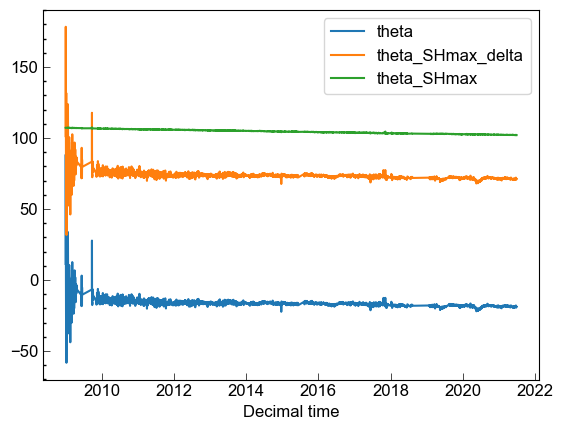

In [40]:
df_deltastrain_all[df_deltastrain_all["triID"] == 80].plot(x="Decimal time", y=["theta", "theta_SHmax_delta", "theta_SHmax"])

**NOTE:** The theta computed from cumulative strain is unstable in the beginning due to the small values. Therefore, we use `theta_SHmax`, which is computed from the reference coordinates as it is more stable.

## Plot for snapshots

In [41]:
# list(range(startdoy, enddoy))
# snapshot list
years_snaps=[2009, 2014, 2020]
doys_snaps=[15, 32, 61]

doyskip = 90 #30
SHmax_len = 400 # [m] factor of orientation length
roundnum = 11

SHmax_angle = 90-(-theta_BPangle + 50) # set from the Gaussian weighted average of strain

print(f"SHmax angle is set as {SHmax_angle:.2f}deg")

for x, y in zip(years_snaps, doys_snaps):
    print(x, y)

SHmax angle is set as 82.67deg
2009 15
2014 32
2020 61


In [42]:
proj_SHmax = Proj(proj='utm',zone=utm_zone_BP,ellps='WGS84', preserve_units=False)

for snapyear, snapdoy in zip(years_snaps, doys_snaps):
    print(snapyear, snapdoy)
    # Select the strain field at snap year-doy.
    df_snap = df_deltastrain_all[(df_deltastrain_all["year"] == snapyear) & (df_deltastrain_all["doy"] == snapdoy)].sort_values(by="triID")

    if df_snap.empty:# no data exists in this time snap
        print(f"no data at {snapyear} {snapdoy}. skipping.")
        continue

    fo_dilatation = open(polyoutputdir+f"/dilation/BP_dilatation_{snapyear}_{snapdoy}.dat", "wt")
    fo_shear = open(polyoutputdir+f"/maxshear/BP_shear_{snapyear}_{snapdoy}.dat", "wt")
    fo_SHmax= open(polyoutputdir+f"/SHmax/BP_SHmax_{snapyear}_{snapdoy}.dat", "wt")

    # strain component
    fo_comp = dict()
    for comp in ["Eee", "Enn", "Een", "Efn", "Efp", "Ess", "ESHmax"]:
        fo_comp[comp] = open(polyoutputdir+f"/{comp}/BP_{comp}_{snapyear}_{snapdoy}.dat", "wt")

    for i in range(Ntri):
        snap_triid = i+1
        df_snap_tri = df_snap.loc[df_snap["triID"] == snap_triid]
    #     print(i, snap_triid, df_snap_tri)

        # get edges 
        df_snap_ref = df_refsnap.loc[df_refsnap["triID"]==snap_triid]
        lon1, lat1 = (df_snap_ref["lon1"].values[0], df_snap_ref["lat1"].values[0])
        lon2, lat2 = (df_snap_ref["lon2"].values[0], df_snap_ref["lat2"].values[0])
        lon3, lat3 = (df_snap_ref["lon3"].values[0], df_snap_ref["lat3"].values[0])
        mlon, mlat = (np.mean([lon1,lon2,lon3]), np.mean([lat1,lat2,lat3]))

        if df_snap_tri.empty:
            # This triangle does not have data at this time snap.
            I1 = np.nan
            maxshear = np.nan
            theta_SHmax_tri = np.nan
            straincomp_dict = dict(Eee=np.nan, Enn=np.nan, Een=np.nan, Efn=np.nan, Efp=np.nan, Ess=np.nan, ESHmax=np.nan)

        else:
            assert len(df_snap_tri) == 1
            I1 = (df_snap_tri["E1"].values[0] + df_snap_tri["E2"].values[0]) * 1e6 #epsilon -> micro epsilon
            maxshear = ((df_snap_tri["E1"].values[0] - df_snap_tri["E2"].values[0])/2)  * 1e6 #see equation 24 in ESESES ATBD document.
            theta_SHmax_tri = df_snap_tri['theta_SHmax'].values[0]

            # rotate strain
            straincomp_dict = dict(Eee=df_snap_tri["Eee"].values[0]*1e6, Enn=df_snap_tri["Enn"].values[0]*1e6, Een=df_snap_tri["Een"].values[0]*1e6)
            Efn, Efp, Ess = rotate_strain(straincomp_dict["Eee"], straincomp_dict["Enn"], straincomp_dict["Een"], theta_BPangle)
            straincomp_dict["Efn"] = Efn
            straincomp_dict["Efp"] = Efp
            straincomp_dict["Ess"] = -Ess # Flip the sign for the sake of right-lateral slip sense
            
            # orientation of SHmax
            ESHmax = compute_axialstrain(straincomp_dict["Eee"], straincomp_dict["Enn"], straincomp_dict["Een"], SHmax_angle)
            straincomp_dict["ESHmax"] = ESHmax

        #--------------------------------#
        #Write polygon file
        #--------------------------------#
        fo_dilatation.write("> -Z{}\n".format(np.round(I1, roundnum)))
        fo_dilatation.write(f"{lon1} {lat1}\n{lon2} {lat2}\n{lon3} {lat3}\n")

        fo_shear.write("> -Z{}\n".format(np.round(maxshear, roundnum)))
        fo_shear.write(f"{lon1} {lat1}\n{lon2} {lat2}\n{lon3} {lat3}\n")

        for comp in ["Eee", "Enn", "Een", "Efn", "Efp", "Ess", "ESHmax"]:
    #         print(comp, straincomp_dict[comp])
            fo_comp[comp].write("> -Z{}\n".format(np.round(straincomp_dict[comp], roundnum)))
            fo_comp[comp].write(f"{lon1} {lat1}\n{lon2} {lat2}\n{lon3} {lat3}\n")

        # compute the orientation of SHmax line
        # UPDATE: compute the line with utm coordinate, then project to lat lon
        mx, my=proj_SHmax(mlon, mlat)
        
        x1 = mx + SHmax_len*np.cos(np.deg2rad(theta_SHmax_tri))
        x2 = mx - SHmax_len*np.cos(np.deg2rad(theta_SHmax_tri))
        y1 = my + SHmax_len*np.sin(np.deg2rad(theta_SHmax_tri))
        y2 = my - SHmax_len*np.sin(np.deg2rad(theta_SHmax_tri))
        print(theta_SHmax_tri, x1-mx, y1-my, x2-mx, y2-my)
        
        # project back to lon ant lat
        x1lon, x1lat =  proj_SHmax(x1, y1, inverse=True)
        x2lon, x2lat =  proj_SHmax(x2, y2, inverse=True)
        fo_SHmax.write(f">\n{x1lon} {x1lat}\n{x2lon} {x2lat}\n")

    fo_dilatation.close()
    fo_shear.close()
    for comp in ["Eee", "Enn", "Een", "Efn", "Efp", "Ess", "ESHmax"]:
        fo_comp[comp].close()

2009 15
109.18 -131.4147908674786 377.7964435266331 131.4147908674786 -377.7964435266331
122.9 -217.26977998029906 335.84794581355527 217.26977998029906 -335.84794581355527
151.86 -352.71912909985986 188.65104284649715 352.71912909985986 -188.65104284649715
167.24 -390.12151467381045 88.34706440288574 390.12151467381045 -88.34706440288574
84.75 36.60064746532589 398.3219710299745 -36.60064746532589 -398.3219710299745
129.29 -253.2983209543163 309.58029750268906 253.2983209543163 -309.58029750268906
166.61 -389.1265244130045 92.63124741846696 389.1265244130045 -92.63124741846696
47.59 269.7725048334105 295.335056564305 -269.7725048334105 -295.335056564305
50.46 254.64670432335697 308.47213160572574 -254.64670432335697 -308.47213160572574
78.97 76.5291791955242 392.61085661454126 -76.5291791955242 -392.61085661454126
2.44 399.6373407598585 17.02926511550322 -399.6373407598585 -17.02926511550322
90.45 -3.141560355434194 399.9876630580984 3.141560355434194 -399.9876630580984
67.19 155.0705

## Search the snaps for master plot

In [43]:
df_deltastrain_all = pd.read_csv("../data/df_deltastrain_all.csv")

In [44]:
dicimaltimelist = np.unique(df_deltastrain_all["Decimal time"])

In [45]:
numdata_all = []
for dct in dicimaltimelist:
    numdata_all.append(len(df_deltastrain_all[df_deltastrain_all["Decimal time"]==dct]))

Text(0, 0.5, 'number of valid elements')

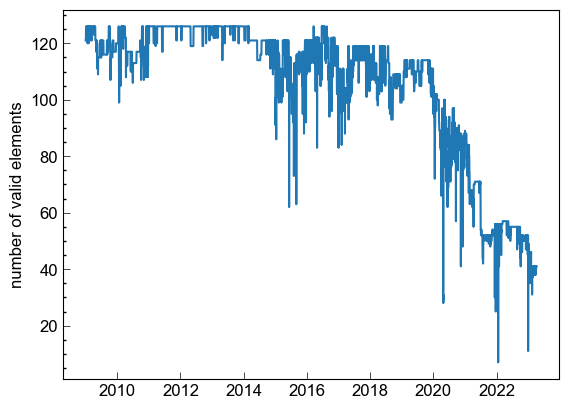

In [46]:
plt.plot(dicimaltimelist, numdata_all)
plt.ylabel("number of valid elements")

In [47]:
#Pick year and data
year=2014
doy=121
for doy in range(366):
    print(doy, len(df_deltastrain_all[ (df_deltastrain_all["year"]==year) & (df_deltastrain_all["doy"]==doy) ]))

0 126
1 126
2 126
3 126
4 126
5 126
6 121
7 121
8 121
9 121
10 121
11 121
12 121
13 121
14 121
15 121
16 121
17 121
18 121
19 121
20 121
21 121
22 126
23 126
24 126
25 126
26 126
27 126
28 126
29 126
30 126
31 126
32 126
33 126
34 126
35 126
36 126
37 126
38 126
39 126
40 126
41 126
42 126
43 126
44 126
45 126
46 126
47 126
48 126
49 126
50 126
51 126
52 120
53 120
54 120
55 126
56 126
57 126
58 126
59 121
60 121
61 121
62 121
63 121
64 121
65 121
66 121
67 121
68 121
69 121
70 121
71 121
72 121
73 121
74 121
75 121
76 121
77 121
78 121
79 121
80 121
81 121
82 121
83 121
84 121
85 121
86 121
87 121
88 121
89 121
90 121
91 121
92 121
93 121
94 121
95 121
96 121
97 121
98 121
99 121
100 121
101 121
102 121
103 121
104 121
105 121
106 121
107 121
108 121
109 121
110 121
111 121
112 121
113 121
114 121
115 121
116 121
117 121
118 121
119 121
120 121
121 121
122 121
123 121
124 121
125 121
126 121
127 121
128 121
129 121
130 121
131 121
132 121
133 121
134 121
135 121
136 121
137 121
138 12